# Data Exploration

1. Generate target variable
2. convert release date into correct format
3. generate days since release variable
4. check for correlation between variables and remove highly correlated variables
5. separate track and album names along with target to try and do some NLP analysis
    1. remove word stems (keep only body of the word)
    2. identify and remove filler words
    3. check and see correlation between certain words and target variable

In [1]:
# Importing required libraries and modules
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from datetime import datetime

warnings.filterwarnings('ignore')

In [2]:
raw_data = pd.read_csv('../data/processed/track_features.csv')
raw_data.head()

,track,artist,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,...,time_signature,chorus_hit,sections,target,album,release_type,release_date,release_date_precision,explicit,popularities
0,Walking Blues,Big Joe Williams,spotify:track:1ZjN5X8LmUB67pWPgimW3B,0.509,0.277,6,-14.323,1,0.0495,0.827,...,4,68.46530,7,0,Walking Blues,album,1981-01-01,day,False,0
1,Suddenly Last Summer,The Motels,spotify:track:4fLIM0B1WwrLux9RdnMvze,0.716,0.753,2,-5.682,1,0.0286,0.162,...,4,57.71583,11,1,Classic Masters,album,2002-01-01,day,False,31
2,Sanctuary,Béla Fleck,spotify:track:3DwlNfiCQSdj0GOxYkR9Rq,0.360,0.542,5,-13.885,1,0.0339,0.368,...,4,30.34574,17,0,Drive,album,1988-01-01,day,False,13
3,The Wild Rover,The Pogues,spotify:track:6JyYNPLalPgGa7XnclF5FO,0.656,0.512,7,-11.872,1,0.0290,0.585,...,3,50.97022,7,0,Red Roses for Me (Expanded Edition),album,1984,year,False,49
4,In The Driver's Seat,John Schneider,spotify:track:6jJi8OXF5qaFdysB6sjWIT,0.642,0.889,2,-5.620,0,0.0494,0.375,...,4,33.62053,7,1,The Dukes Of Hazzard,album,1978,year,False,21


In [3]:
raw_data.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature,chorus_hit,sections,target,popularities
count,24698.000000,24698.000000,24698.000000,24698.000000,24698.000000,24698.000000,24698.000000,24698.000000,24698.000000,24698.000000,24698.000000,2.469800e+04,24698.000000,24698.000000,24698.000000,24698.00000,24698.000000
mean,0.560788,0.642772,5.263220,-9.113158,0.662564,0.080085,0.254221,0.153554,0.197884,0.514222,120.915787,2.512168e+05,3.923719,40.595865,10.942789,0.50000,29.132197
std,0.183826,0.246324,3.572534,5.277124,0.472845,0.085404,0.307256,0.303221,0.171552,0.261718,29.133453,1.105231e+05,0.373012,19.702683,4.669843,0.50001,24.814525
min,0.057600,0.000251,0.000000,-49.253000,0.000000,0.022000,0.000000,0.000000,0.013000,0.000000,34.535000,1.592000e+04,0.000000,0.000000,1.000000,0.00000,0.000000
25%,0.442000,0.485000,2.000000,-11.417750,0.000000,0.034600,0.012900,0.000000,0.091500,0.302000,98.385250,2.008900e+05,4.000000,27.775602,9.000000,0.00000,2.000000
50%,0.579000,0.684000,5.000000,-7.765000,1.000000,0.046700,0.104000,0.000093,0.128000,0.524000,119.773000,2.357935e+05,4.000000,36.057290,10.000000,0.50000,28.000000
75%,0.695000,0.843000,8.000000,-5.465000,1.000000,0.082700,0.417000,0.056075,0.260000,0.731000,138.832500,2.798930e+05,4.000000,48.027440,12.000000,1.00000,50.000000
max,0.988000,1.000000,11.000000,1.137000,1.000000,0.956000,0.996000,1.000000,0.997000,0.996000,217.943000,4.170227e+06,5.000000,433.182000,169.000000,1.00000,91.000000


array([[<Axes: title={'center': 'popularities'}>]], dtype=object)

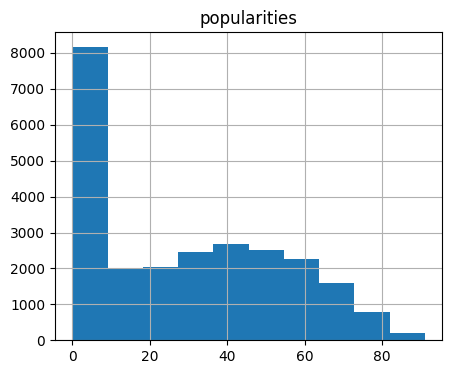

In [4]:
%matplotlib inline
raw_data.hist(column=['popularities'], bins=10, figsize=(5, 4))

In [5]:
condition = raw_data['popularities'] > 50

num_greater_rows = condition.sum()

total_rows = len(raw_data)

(num_greater_rows / total_rows) * 100

24.034334763948497

In [6]:
raw_data['target_popularity'] = raw_data.popularities.apply(lambda x: 1 if x > 50 else 0)

In [7]:
raw_data.target_popularity.value_counts()

target_popularity
0    18762
1     5936
Name: count, dtype: int64

In [8]:
raw_data.groupby('target_popularity').danceability.mean()

target_popularity
0    0.539951
1    0.626648
Name: danceability, dtype: float64

In [9]:
raw_data.drop(raw_data[raw_data.release_date == '0000'].index, inplace=True)

In [10]:
def get_correct_format(date_str, precision):
    if precision == 'year':
        return f'{date_str}-01-01'
    elif precision == 'month':
        return f'{date_str}-01'
    else:
        return date_str
    

In [11]:
raw_data['release_date'] = raw_data.apply(lambda x: get_correct_format(x['release_date'], x['release_date_precision']), axis=1)

In [12]:
raw_data.head()

,track,artist,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,...,chorus_hit,sections,target,album,release_type,release_date,release_date_precision,explicit,popularities,target_popularity
0,Walking Blues,Big Joe Williams,spotify:track:1ZjN5X8LmUB67pWPgimW3B,0.509,0.277,6,-14.323,1,0.0495,0.827,...,68.46530,7,0,Walking Blues,album,1981-01-01,day,False,0,0
1,Suddenly Last Summer,The Motels,spotify:track:4fLIM0B1WwrLux9RdnMvze,0.716,0.753,2,-5.682,1,0.0286,0.162,...,57.71583,11,1,Classic Masters,album,2002-01-01,day,False,31,0
2,Sanctuary,Béla Fleck,spotify:track:3DwlNfiCQSdj0GOxYkR9Rq,0.360,0.542,5,-13.885,1,0.0339,0.368,...,30.34574,17,0,Drive,album,1988-01-01,day,False,13,0
3,The Wild Rover,The Pogues,spotify:track:6JyYNPLalPgGa7XnclF5FO,0.656,0.512,7,-11.872,1,0.0290,0.585,...,50.97022,7,0,Red Roses for Me (Expanded Edition),album,1984-01-01,year,False,49,0
4,In The Driver's Seat,John Schneider,spotify:track:6jJi8OXF5qaFdysB6sjWIT,0.642,0.889,2,-5.620,0,0.0494,0.375,...,33.62053,7,1,The Dukes Of Hazzard,album,1978-01-01,year,False,21,0


In [13]:
raw_data['release_date'] = raw_data.release_date.apply(lambda x: pd.to_datetime(x))
raw_data.head(20)

,track,artist,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,...,chorus_hit,sections,target,album,release_type,release_date,release_date_precision,explicit,popularities,target_popularity
0,Walking Blues,Big Joe Williams,spotify:track:1ZjN5X8LmUB67pWPgimW3B,0.5090,0.2770,6,-14.323,1,0.0495,0.827000,...,68.46530,7,0,Walking Blues,album,1981-01-01,day,False,0,0
1,Suddenly Last Summer,The Motels,spotify:track:4fLIM0B1WwrLux9RdnMvze,0.7160,0.7530,2,-5.682,1,0.0286,0.162000,...,57.71583,11,1,Classic Masters,album,2002-01-01,day,False,31,0
2,Sanctuary,Béla Fleck,spotify:track:3DwlNfiCQSdj0GOxYkR9Rq,0.3600,0.5420,5,-13.885,1,0.0339,0.368000,...,30.34574,17,0,Drive,album,1988-01-01,day,False,13,0
3,The Wild Rover,The Pogues,spotify:track:6JyYNPLalPgGa7XnclF5FO,0.6560,0.5120,7,-11.872,1,0.0290,0.585000,...,50.97022,7,0,Red Roses for Me (Expanded Edition),album,1984-01-01,year,False,49,0
4,In The Driver's Seat,John Schneider,spotify:track:6jJi8OXF5qaFdysB6sjWIT,0.6420,0.8890,2,-5.620,0,0.0494,0.375000,...,33.62053,7,1,The Dukes Of Hazzard,album,1978-01-01,year,False,21,0
5,Slow Kill,Fields Of The Nephilim,spotify:track:3AKzRH32S4Jc5Ge4RFp5WG,0.2960,0.5470,4,-15.115,0,0.0327,0.000291,...,53.02555,11,0,Dawnrazor,album,1987-05-04,day,False,0,0
6,Young Wild And Free,Brighton Rock,spotify:track:7EBpncUwlHjLhQTetSLb9O,0.4540,0.7340,2,-15.559,1,0.0410,0.124000,...,36.52688,11,0,"Young, Wild And Free",album,1986-01-01,year,False,11,0
7,Holiday,The Other Ones,spotify:track:3f1rbdXIbz36QZ8xU7wt2i,0.4870,0.8530,11,-10.165,0,0.0343,0.027700,...,15.23401,10,1,The Other Ones (2019 remaster),album,1986-10-14,day,False,4,0
8,Answering Machine,Rupert Holmes,spotify:track:5Qo14bQqTK9iGbf2g6JUjL,0.7750,0.4880,0,-15.044,1,0.1230,0.240000,...,28.65643,9,1,Partners In Crime,album,1979-01-01,day,False,35,0
9,Crystal Ball,Yngwie Malmsteen,spotify:track:6C3BPDXuHFRbCWsTk4eNPU,0.4060,0.7770,8,-11.498,1,0.0590,0.087000,...,41.44096,12,0,Odyssey,album,1988-01-01,day,False,33,0


In [14]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 24687 entries, 0 to 24697
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   track                   24687 non-null  object        
 1   artist                  24687 non-null  object        
 2   uri                     24687 non-null  object        
 3   danceability            24687 non-null  float64       
 4   energy                  24687 non-null  float64       
 5   key                     24687 non-null  int64         
 6   loudness                24687 non-null  float64       
 7   mode                    24687 non-null  int64         
 8   speechiness             24687 non-null  float64       
 9   acousticness            24687 non-null  float64       
 10  instrumentalness        24687 non-null  float64       
 11  liveness                24687 non-null  float64       
 12  valence                 24687 non-null  float64    

In [15]:
curr_date = datetime.now()

# raw_data['days_since_release'] = raw_data.release_date.apply(lambda x: curr_date - )
raw_data['days_since_release'] = (curr_date - raw_data['release_date']).dt.days
raw_data.head()

,track,artist,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,...,sections,target,album,release_type,release_date,release_date_precision,explicit,popularities,target_popularity,days_since_release
0,Walking Blues,Big Joe Williams,spotify:track:1ZjN5X8LmUB67pWPgimW3B,0.509,0.277,6,-14.323,1,0.0495,0.827,...,7,0,Walking Blues,album,1981-01-01,day,False,0,0,15804
1,Suddenly Last Summer,The Motels,spotify:track:4fLIM0B1WwrLux9RdnMvze,0.716,0.753,2,-5.682,1,0.0286,0.162,...,11,1,Classic Masters,album,2002-01-01,day,False,31,0,8134
2,Sanctuary,Béla Fleck,spotify:track:3DwlNfiCQSdj0GOxYkR9Rq,0.360,0.542,5,-13.885,1,0.0339,0.368,...,17,0,Drive,album,1988-01-01,day,False,13,0,13248
3,The Wild Rover,The Pogues,spotify:track:6JyYNPLalPgGa7XnclF5FO,0.656,0.512,7,-11.872,1,0.0290,0.585,...,7,0,Red Roses for Me (Expanded Edition),album,1984-01-01,year,False,49,0,14709
4,In The Driver's Seat,John Schneider,spotify:track:6jJi8OXF5qaFdysB6sjWIT,0.642,0.889,2,-5.620,0,0.0494,0.375,...,7,1,The Dukes Of Hazzard,album,1978-01-01,year,False,21,0,16900


In [16]:
raw_data[['days_since_release', 'popularities']].corr()

,days_since_release,popularities
days_since_release,1.000000,-0.079615
popularities,-0.079615,1.000000


In [17]:
raw_data.popularities.value_counts()

popularities
0     5568
1      502
2      359
42     342
38     326
      ... 
86      18
87      15
88       7
89       5
91       1
Name: count, Length: 91, dtype: int64

In [18]:
popular_0_data = raw_data[raw_data['popularities'] == 0].copy()
popular_0_data.head()

,track,artist,uri,danceability,energy,key,loudness,mode,speechiness,acousticness,...,sections,target,album,release_type,release_date,release_date_precision,explicit,popularities,target_popularity,days_since_release
0,Walking Blues,Big Joe Williams,spotify:track:1ZjN5X8LmUB67pWPgimW3B,0.509,0.277,6,-14.323,1,0.0495,0.827000,...,7,0,Walking Blues,album,1981-01-01,day,False,0,0,15804
5,Slow Kill,Fields Of The Nephilim,spotify:track:3AKzRH32S4Jc5Ge4RFp5WG,0.296,0.547,4,-15.115,0,0.0327,0.000291,...,11,0,Dawnrazor,album,1987-05-04,day,False,0,0,13490
12,Coumba,Orchestra Baobab,spotify:track:2hRkoolB3umU4SviReUK4R,0.655,0.304,3,-15.005,1,0.0375,0.751000,...,23,0,Pirates Choice,album,1982-01-01,day,False,0,0,15439
18,Mordor - Live in Munich,Running Wild,spotify:track:586JuEkUz9LMuw359tnENM,0.220,0.924,11,-11.801,0,0.0468,0.000032,...,14,0,Ready For Boarding,album,1988-02-22,day,False,0,0,13196
23,Precious To Me,Phil Seymour,spotify:track:0uDbaQ0mUscJhYV2dn7bNm,0.698,0.867,11,-5.946,0,0.0278,0.018400,...,10,1,"Archive Series, Vol. 1",album,2012-03-08,day,False,0,0,4415


In [19]:
popular_0_data.target.value_counts()

target
0    4546
1    1022
Name: count, dtype: int64

In [21]:
# TODO: Change popularities as well, not just target popularity
raw_data['target_popularity'] = raw_data.apply(lambda x: 1 if (x['target'] == 1 and x['target_popularity'] == 0) else x['target_popularity'], axis=1)

In [22]:
raw_data.target_popularity.value_counts()

target_popularity
1    13027
0    11660
Name: count, dtype: int64

In [23]:
popular_0_data = raw_data[raw_data['popularities'] == 0].copy()
popular_0_data.target.value_counts()

target
0    4546
1    1022
Name: count, dtype: int64